In [26]:
import os
import pickle
from datetime import datetime
from collections import Counter
from tkinter import Tk
from tkinter.filedialog import askopenfilename

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
import joblib

from shapely.geometry import Polygon

from sklearn.model_selection import (
    KFold, train_test_split, GridSearchCV
)
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    f1_score, roc_auc_score, confusion_matrix,
    precision_score, recall_score, accuracy_score
)

import lightgbm as lgb
from lightgbm import (
    early_stopping, log_evaluation,
    LGBMRegressor, plot_importance
)

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
import joblib


In [27]:
def save_target_encoding_maps(train_df, target_column, zone_columns, save_dir="models/encoding_maps"):
    import os
    os.makedirs(save_dir, exist_ok=True)

    for col in zone_columns:
        means = train_df.groupby(col)[target_column].mean()
        mapping = means.to_dict()
        joblib.dump(mapping, os.path.join(save_dir, f"{col}_target_encoding.pkl"))

In [42]:
def filter_grid_to_active_zone_hours(grid: pd.DataFrame) -> pd.DataFrame:
    """
    Filters the grid to only include pickup_zone and pickup_hour combinations 
    that have had at least one recorded trip over the full date range.
    """
    # Compute total trip counts by zone-hour pair
    zone_hour_totals = grid.groupby(['pickup_zone', 'pickup_hour'])['trip_count'].sum().reset_index()

    # Keep only zone-hour pairs with any non-zero activity
    active_zone_hours = zone_hour_totals[zone_hour_totals['trip_count'] > 0][['pickup_zone', 'pickup_hour']]

    # Merge to filter grid
    filtered_grid = grid.merge(active_zone_hours, on=['pickup_zone', 'pickup_hour'], how='inner')

    return filtered_grid

In [43]:
def hotspot_prediction(df, train_months, test_months, target='trip_count', use_log=True):
    
    # Build the grid for every possible combination of zone-date-hour
    zones = df['pickup_zone'].unique()
    dates = pd.date_range(df['pickup_date'].min(), df['pickup_date'].max(), freq='D')
    hours = range(24)
    
    grid = pd.MultiIndex.from_product([zones, dates, hours], names=['pickup_zone', 'pickup_date', 'pickup_hour']).to_frame(index=False)
    
    # Get actual trip counts
    trip_counts = df.groupby(['pickup_zone', 'pickup_date', 'pickup_hour']).size().reset_index(name='trip_count')
    
    grid['pickup_date'] = pd.to_datetime(grid['pickup_date'])
    trip_counts['pickup_date'] = pd.to_datetime(trip_counts['pickup_date'])
    
    # Merge actual trip counts and grid
    grid = grid.merge(trip_counts, on=['pickup_zone', 'pickup_date', 'pickup_hour'], how='left')
    grid['trip_count'] = grid['trip_count'].fillna(0).astype(int)
    grid = filter_grid_to_active_zone_hours(grid)
    grid = grid[grid['trip_count'] > 0]
    
    # Create time-based features
    grid['pickup_date'] = pd.to_datetime(grid['pickup_date'])

    grid['pickup_month'] = grid['pickup_date'].dt.month
    grid['pickup_day_of_week'] = grid['pickup_date'].dt.dayofweek
    grid['is_weekend'] = grid['pickup_day_of_week'].isin([5, 6])
    
    def time_of_day(hour):
        if 0 <= hour < 5:
            return 'Early Morning'
        elif 5 <= hour < 10:
            return 'Morning Rush'
        elif 10 <= hour < 15:
            return 'Midday'
        elif 15 <= hour < 19:
            return 'Evening Rush'
        else:
            return 'Night'

    # Apply it to the grid
    grid['time_of_day'] = grid['pickup_hour'].apply(time_of_day)
    
    # Load POI Density Features
    poi_density_path = "/Users/elliekavanagh/TaxiApp/Notebooks/Hotspot Prediction Model/zones_stats_with_all_densities.csv"
    poi_df = pd.read_csv(poi_density_path)
    poi_df = poi_df.drop_duplicates(subset="zone", keep="first")
    
    # Merge POI Density Features
    df = grid.merge(
        poi_df[[
            "zone", 
            "nightlife_density_per_sq_mile",
            "transit_density_per_sq_mile",
            "hotel_density_per_sq_mile",
            "venues_density_per_sq_mile",
            "restaurant_density_per_sq_mile",
            "tourism_density_per_sq_mile",
            "education_density_per_sq_mile",
            "health_density_per_sq_mile"
        ]], 
        left_on="pickup_zone", right_on="zone", how="left"
    ).drop(columns="zone")
    
    # Generate official US holidays for the year(s)
    us_holidays = holidays.US(years=[2023])  # Add more years if needed

    # Apply holiday flag
    df['is_holiday'] = df['pickup_date'].dt.date.isin(us_holidays)
    
    df['day_time_interaction'] = df['pickup_day_of_week'].astype(str) + "_" + df['time_of_day'].astype(str)
    df['zone_hour_interaction'] = df['pickup_zone'].astype(str) + "_" + df['pickup_hour'].astype(str)
    df['holiday_time_interaction'] = df['is_holiday'].astype(str) + '_' + df['time_of_day'].astype(str)
    df['zone_isweekend_interaction'] = df['pickup_zone'].astype(str) + '_' + df['is_weekend'].astype(str)
    df['hour_isweekend_interaction'] = df['pickup_hour'].astype(str) + '_' + df['is_weekend'].astype(str)
    df['zone_time_isweekend_interaction'] = df['pickup_zone'].astype(str) + '_' + df['time_of_day'].astype(str) + "_" + df['is_weekend'].astype(str)
    df['zone_hour_isweekend_interaction'] = df['pickup_zone'].astype(str) + '_' + df['pickup_hour'].astype(str) + "_" + df['is_weekend'].astype(str)
    df['zone_hour_holiday_interaction'] = df['pickup_zone'].astype(str) + '_' + df['pickup_hour'].astype(str) + "_" + df['is_holiday'].astype(str)

    # Interaction features for POIs
    df['nightlife_x_hotels'] = (
        df['nightlife_density_per_sq_mile'] * 
        df['hotel_density_per_sq_mile']
    )

    df['restaurants_x_tourism'] = (
        df['restaurant_density_per_sq_mile'] *
        df['tourism_density_per_sq_mile']
    )

    df['hotels_x_tourism'] = (
        df['hotel_density_per_sq_mile'] * 
        df['tourism_density_per_sq_mile']
    )

    df['venues_x_nightlife'] = (
        df['venues_density_per_sq_mile'] *
        df['nightlife_density_per_sq_mile']
    )

    df['transit_x_all_pois'] = (
        df['transit_density_per_sq_mile'] * (
            df['restaurant_density_per_sq_mile'] +
            df['tourism_density_per_sq_mile'] +
            df['venues_density_per_sq_mile'] +
            df['education_density_per_sq_mile'] +
            df['health_density_per_sq_mile']
        )
    )

    # POI + time interaction features
    df['nightlife_x_isweekend'] = df['nightlife_density_per_sq_mile'] * df['is_weekend'].astype(int)
    df['education_x_isweekend'] = df['education_density_per_sq_mile'] * df['is_weekend'].astype(int)
    df['health_x_isweekend'] = df['health_density_per_sq_mile'] * df['is_weekend'].astype(int)
    df['venues_x_isweekend'] = df['venues_density_per_sq_mile'] * df['is_weekend'].astype(int)
    df['tourism_x_isweekend'] = df['tourism_density_per_sq_mile'] * df['is_weekend'].astype(int)
    df['hotel_x_isweekend'] = df['hotel_density_per_sq_mile'] * df['is_weekend'].astype(int)
    df['transit_x_isweekend'] = df['transit_density_per_sq_mile'] * df['is_weekend'].astype(int)
    df['restaurants_x_isweekend'] = df['restaurant_density_per_sq_mile'] * df['is_weekend'].astype(int)

    # Define the list of POI density features
    poi_density_features = {
        "nightlife": "nightlife_density_per_sq_mile",
        "education": "education_density_per_sq_mile",
        "health": "health_density_per_sq_mile",
        "venues": "venues_density_per_sq_mile",
        "tourism": "tourism_density_per_sq_mile",
        "hotel": "hotel_density_per_sq_mile",
        "transit": "transit_density_per_sq_mile",
        "restaurants": "restaurant_density_per_sq_mile"
    }

    # Loop through each POI type and time_of_day bucket to create interactions
    for poi_label, poi_col in poi_density_features.items():
        for tod in df["time_of_day"].unique():
            safe_tod = tod.replace(" ", "_")  # avoid spaces in column names
            col_name = f"{poi_label}_x_{safe_tod}"
            df[col_name] = df[poi_col] * (df["time_of_day"] == tod).astype(int)

    trip_counts = df.sort_values(['pickup_zone', 'pickup_hour'])

    trip_counts['datetime'] = pd.to_datetime(trip_counts['pickup_date']) + pd.to_timedelta(trip_counts['pickup_hour'], unit='h')
    trip_counts = trip_counts.sort_values(['pickup_zone', 'datetime']).reset_index(drop=True)

    # Create lag features (past trip counts)
    trip_counts['trip_count_1h_ago'] = trip_counts.groupby('pickup_zone')['trip_count'].shift(1).fillna(0)
    trip_counts['trip_count_2h_ago'] = trip_counts.groupby('pickup_zone')['trip_count'].shift(2).fillna(0)

    # Rolling average for past 2 hours
    trip_counts['rolling_avg_2h'] = (trip_counts['trip_count_1h_ago'] + trip_counts['trip_count_2h_ago']) / 2

    trip_counts = trip_counts.drop(['datetime'], axis=1)
    
    # Split test and training data
    # Ensure your date ranges are accurate
    train_mask = trip_counts['pickup_date'].dt.month == train_months
    test_mask = trip_counts['pickup_date'].dt.month == test_months

    train_df = trip_counts[train_mask].copy()


    print(train_df['trip_count'].describe())

    train_df['trip_count'].hist(bins=100)
    plt.title("Distribution of trip_count (per zone-hour)")
    plt.xlabel("trip_count")
    plt.ylabel("frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    test_df = trip_counts[test_mask].copy()

    print(f"Train shape: {train_df.shape}")
    print(f"Test shape: {test_df.shape}")
    
    train_df['log_trip_count'] = np.log1p(train_df['trip_count'])
    test_df['log_trip_count'] = np.log1p(test_df['trip_count'])
    
    # Define target and features
    target_column = 'log_trip_count'

    # Step 1: Create log-transformed target columns
    train_df['log_trip_count'] = np.log1p(train_df['trip_count'])
    test_df['log_trip_count'] = np.log1p(test_df['trip_count'])

    # Step 2: Drop raw trip_count (optional but cleaner)
    X_train = train_df.drop(columns=['trip_count', target_column])
    y_train = train_df[target_column]

    X_test = test_df.drop(columns=['trip_count', target_column])
    y_test = test_df[target_column]

    # Step 3: Add log_trip_count back if needed for encoding or merging
    X_train_full = X_train.copy()
    X_train_full[target_column] = y_train

    X_test_full = X_test.copy()
    X_test_full[target_column] = y_test
    
    # Base encoding 
    def base_encode(df):
        df_encoded = df.copy()
        df_encoded['is_weekend'] = df_encoded['is_weekend'].astype(int)
        time_order = {
            'Early Morning': 0, 'Morning Rush': 1, 'Midday': 2, 'Evening Rush': 3, 'Night': 4
        }
        df_encoded['time_of_day_encoded'] = df_encoded['time_of_day'].map(time_order)
        df_encoded.drop('time_of_day', axis=1, inplace=True)
        
        
        return df_encoded

    #  Target Encoding 
    def target_encode_train_and_apply(train_df, test_df, target_column, zone_column):
        train_encoded = train_df.copy()
        test_encoded = test_df.copy()
        kf = KFold(n_splits=5, shuffle=True, random_state=42)

        for col in zone_column:
            new_col = f"{col}_target_encoded"
            train_encoded[new_col] = np.nan
            for train_idx, val_idx in kf.split(train_df):
                train_fold, val_fold = train_df.iloc[train_idx], train_df.iloc[val_idx]
                means = train_fold.groupby(col)[target_column].mean()
                train_encoded.loc[val_fold.index, new_col] = val_fold[col].map(means)
            final_means = train_df.groupby(col)[target_column].mean()
            test_encoded[new_col] = test_df[col].map(final_means)
            train_encoded.drop(columns=col, inplace=True)
            test_encoded.drop(columns=col, inplace=True)
        return train_encoded, test_encoded


    #  Base encode the full data with target temporarily added
    train_base = base_encode(X_train_full)
    test_base = base_encode(X_test_full)

    #  Target encode the zone columns
    train_encoded, test_encoded = target_encode_train_and_apply(
        train_base, test_base,
        target_column='log_trip_count',
        zone_column=['pickup_zone', 'day_time_interaction', 'zone_hour_interaction', 'holiday_time_interaction', 'zone_isweekend_interaction', 'hour_isweekend_interaction', 'zone_time_isweekend_interaction', 'zone_hour_isweekend_interaction', 'zone_hour_holiday_interaction']
    )
    
    # After target encoding train_encoded is ready, call:
    save_target_encoding_maps(
        train_base,  # or train_encoded before dropping original columns
        target_column='log_trip_count',
        zone_columns=[
            'pickup_zone', 'day_time_interaction', 'zone_hour_interaction',
            'holiday_time_interaction', 'zone_isweekend_interaction',
            'hour_isweekend_interaction', 'zone_time_isweekend_interaction',
            'zone_hour_isweekend_interaction', 'zone_hour_holiday_interaction'
        ]
    )
    
    
    #  Drop datetime columns
    for col in ['pickup_date', 'tpep_pickup_datetime']:
        train_encoded.drop(columns=col, errors='ignore', inplace=True)
        test_encoded.drop(columns=col, errors='ignore', inplace=True)

    #  Drop the target from the features
    X_train_final = train_encoded.drop(columns=['log_trip_count'])
    X_test_final = test_encoded.drop(columns=['log_trip_count'])

    # Final check
    print("Final training columns:", X_train_final.columns)

    # Prepare data
    X_train = train_encoded.drop(columns='log_trip_count')
    y_train = train_encoded['log_trip_count']
    X_test = test_encoded.drop(columns='log_trip_count')
    y_test = test_encoded['log_trip_count']

    # Define LightGBM regression model
    model = LGBMRegressor(
        objective='regression',
        verbosity=-1,
        random_state=42
    )

    # Hyperparameter grid
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'n_estimators': [100, 200]
    }

    # Grid search
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='neg_root_mean_squared_error',
        cv=3,
        verbose=1,
        n_jobs=-1
    )

    # Fit grid search
    grid.fit(X_train, y_train)

    # Best model
    best_model = grid.best_estimator_
    log_preds = best_model.predict(X_test)

    # Inverse log-transform
    y_pred = np.expm1(log_preds)
    y_true = np.expm1(y_test)

    # Evaluation 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # Manual RMSE
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print("Best Parameters:", grid.best_params_)
    print("Evaluation on Test Set (Original Scale):")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R² Score: {r2:.2f}")

    # Plot actual vs predicted
    plt.figure(figsize=(8, 5))
    plt.scatter(y_true, y_pred, alpha=0.3)
    plt.xlabel("Actual Trip Count")
    plt.ylabel("Predicted Trip Count")
    plt.title(f"LightGBM: Actual vs Predicted (Test Month: {test_months})")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Feature importance
    plt.figure(figsize=(15, 12))
    plot_importance(best_model.booster_, max_num_features=30, importance_type='gain')
    plt.title("LightGBM Feature Importance (Top 15)")
    plt.tight_layout()
    plt.show()


    return best_model, grid.best_params_, rmse, mae, r2



In [39]:
# Base directory for all monthly CSVs
base_dir = "/Users/elliekavanagh/Downloads/Monthly Data"

In [40]:
# Define month-to-file mapping using "Clean_<Month>_Taxi.csv"
month_file_map = {
    1: "Clean_January_Taxi.csv",
    2: "Clean_February_Taxi.csv",
    3: "Clean_March_Taxi.csv",
    4: "Clean_April_Taxi.csv",
    5: "Clean_May_Taxi.csv",
    6: "Clean_June_Taxi.csv",
    7: "Clean_July_Taxi.csv",
    8: "Clean_August_Taxi.csv",
    9: "Clean_September_Taxi.csv",
    10: "Clean_October_Taxi.csv",
    11: "Clean_November_Taxi.csv",
    12: "Clean_December_Taxi.csv",
}


count    155341.000000
mean         18.481972
std          51.367346
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max         686.000000
Name: trip_count, dtype: float64


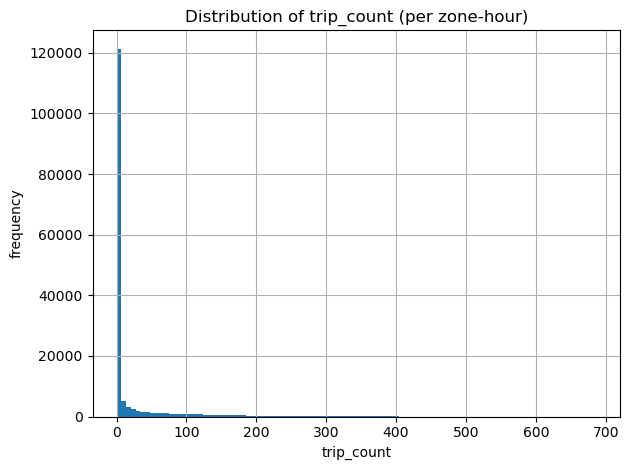

Train shape: (155341, 81)
Test shape: (140308, 81)
Final training columns: Index(['pickup_hour', 'pickup_month', 'pickup_day_of_week', 'is_weekend',
       'nightlife_density_per_sq_mile', 'transit_density_per_sq_mile',
       'hotel_density_per_sq_mile', 'venues_density_per_sq_mile',
       'restaurant_density_per_sq_mile', 'tourism_density_per_sq_mile',
       'education_density_per_sq_mile', 'health_density_per_sq_mile',
       'is_holiday', 'nightlife_x_hotels', 'restaurants_x_tourism',
       'hotels_x_tourism', 'venues_x_nightlife', 'transit_x_all_pois',
       'nightlife_x_isweekend', 'education_x_isweekend', 'health_x_isweekend',
       'venues_x_isweekend', 'tourism_x_isweekend', 'hotel_x_isweekend',
       'transit_x_isweekend', 'restaurants_x_isweekend',
       'nightlife_x_Early_Morning', 'nightlife_x_Morning_Rush',
       'nightlife_x_Midday', 'nightlife_x_Evening_Rush', 'nightlife_x_Night',
       'education_x_Early_Morning', 'education_x_Morning_Rush',
       'education_

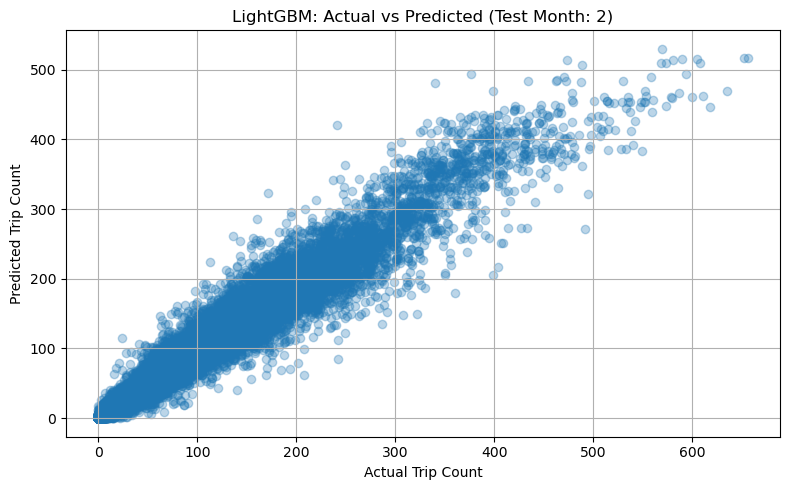

<Figure size 1500x1200 with 0 Axes>

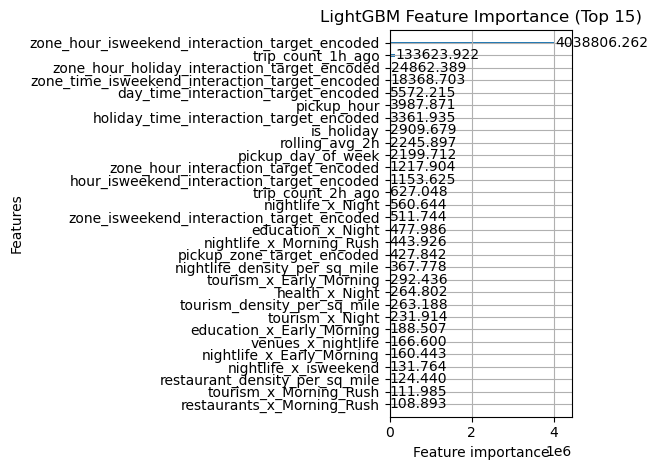

count    142128.000000
mean         19.270672
std          53.057932
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max         656.000000
Name: trip_count, dtype: float64


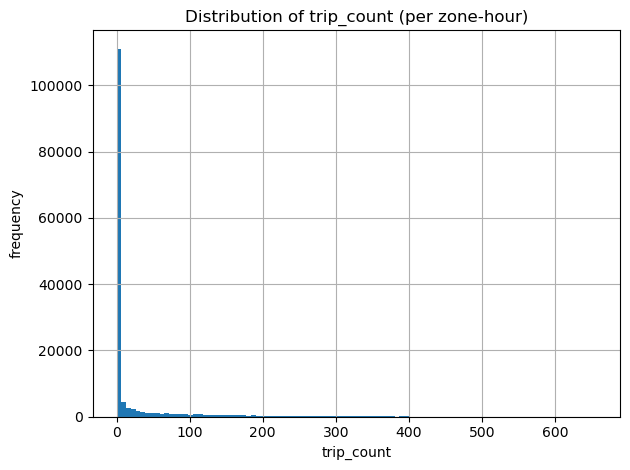

Train shape: (142128, 81)
Test shape: (157356, 81)


KeyboardInterrupt: 

In [44]:
results = []
os.makedirs("models", exist_ok=True)  # Create model output folder

for train_month in range(1, 12):  # Jan to Nov as training months
    test_month = train_month + 1  # Feb to Dec as test months

    # Load both train and test month files
    train_file = month_file_map[train_month]
    test_file = month_file_map[test_month]

    train_path = os.path.join(base_dir, train_file)
    test_path = os.path.join(base_dir, test_file)

    # Read and label train data
    df_train = pd.read_csv(train_path, parse_dates=['pickup_date'])
    df_train['pickup_month'] = df_train['pickup_date'].dt.month

    # Read and label test data
    df_test = pd.read_csv(test_path, parse_dates=['pickup_date'])
    df_test['pickup_month'] = df_test['pickup_date'].dt.month

    # Combine both months
    df = pd.concat([df_train, df_test], ignore_index=True)

    # Run prediction function
    model, params, rmse, mae, r2 = hotspot_prediction(
        df=df,
        train_months=train_month,
        test_months=test_month,
    )

    results.append({
        "train_month": train_month,
        "test_month": test_month,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "params": params
    })


In [33]:
import matplotlib.pyplot as plt
train_df['trip_count'].hist(bins=100)
plt.title("Distribution of trip_count (per zone-hour)")
plt.xlabel("trip_count")
plt.ylabel("frequency")

NameError: name 'train_df' is not defined

Loading: /Users/elliekavanagh/Downloads/Monthly Data/Clean_January_Taxi.csv + /Users/elliekavanagh/Downloads/Monthly Data/Clean_February_Taxi.csv
Train shape: (188976, 81)
Test shape: (170688, 81)
Final training columns: Index(['pickup_hour', 'pickup_month', 'pickup_day_of_week', 'is_weekend',
       'nightlife_density_per_sq_mile', 'transit_density_per_sq_mile',
       'hotel_density_per_sq_mile', 'venues_density_per_sq_mile',
       'restaurant_density_per_sq_mile', 'tourism_density_per_sq_mile',
       'education_density_per_sq_mile', 'health_density_per_sq_mile',
       'is_holiday', 'nightlife_x_hotels', 'restaurants_x_tourism',
       'hotels_x_tourism', 'venues_x_nightlife', 'transit_x_all_pois',
       'nightlife_x_isweekend', 'education_x_isweekend', 'health_x_isweekend',
       'venues_x_isweekend', 'tourism_x_isweekend', 'hotel_x_isweekend',
       'transit_x_isweekend', 'restaurants_x_isweekend',
       'nightlife_x_Early_Morning', 'nightlife_x_Morning_Rush',
       'nightl

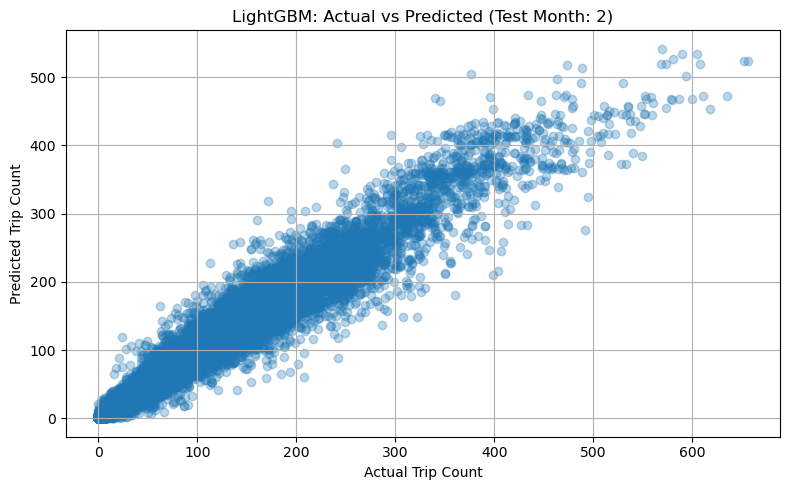

<Figure size 1500x1200 with 0 Axes>

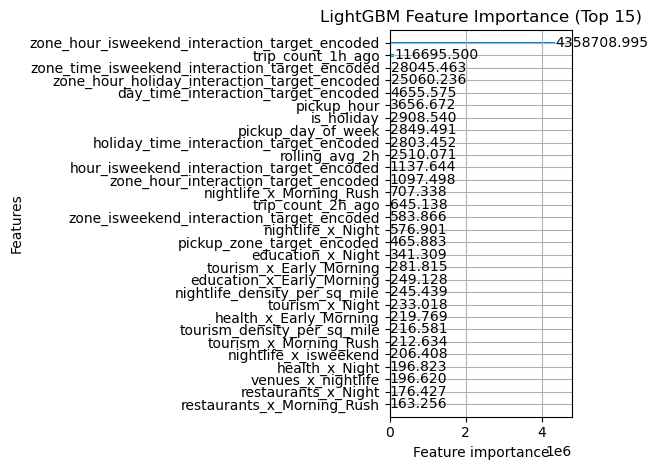

Saved model to: models/hotspot_model_1_to_2.pkl
Loading: /Users/elliekavanagh/Downloads/Monthly Data/Clean_February_Taxi.csv + /Users/elliekavanagh/Downloads/Monthly Data/Clean_March_Taxi.csv
Train shape: (173376, 81)
Test shape: (191952, 81)
Final training columns: Index(['pickup_hour', 'pickup_month', 'pickup_day_of_week', 'is_weekend',
       'nightlife_density_per_sq_mile', 'transit_density_per_sq_mile',
       'hotel_density_per_sq_mile', 'venues_density_per_sq_mile',
       'restaurant_density_per_sq_mile', 'tourism_density_per_sq_mile',
       'education_density_per_sq_mile', 'health_density_per_sq_mile',
       'is_holiday', 'nightlife_x_hotels', 'restaurants_x_tourism',
       'hotels_x_tourism', 'venues_x_nightlife', 'transit_x_all_pois',
       'nightlife_x_isweekend', 'education_x_isweekend', 'health_x_isweekend',
       'venues_x_isweekend', 'tourism_x_isweekend', 'hotel_x_isweekend',
       'transit_x_isweekend', 'restaurants_x_isweekend',
       'nightlife_x_Early_Mornin

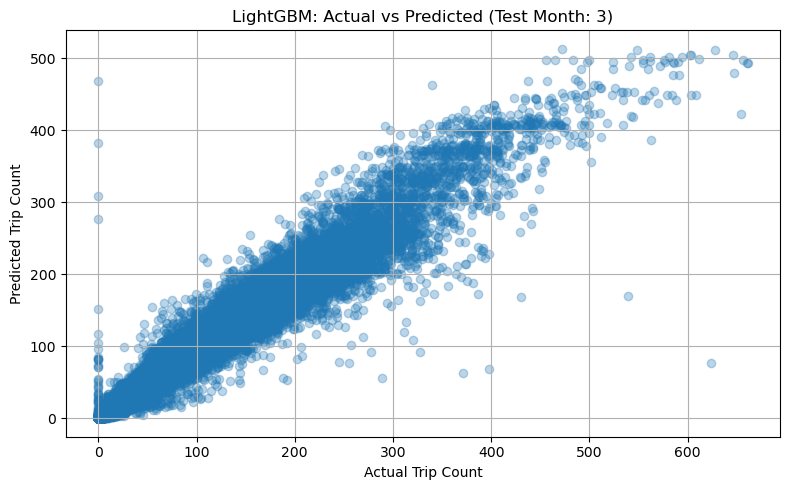

<Figure size 1500x1200 with 0 Axes>

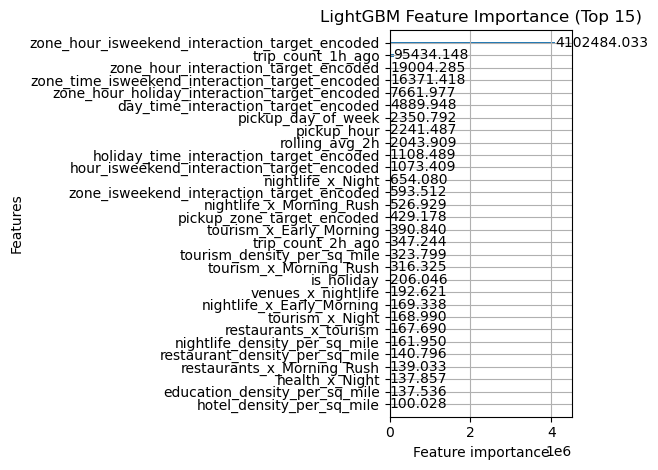

Saved model to: models/hotspot_model_2_to_3.pkl
Loading: /Users/elliekavanagh/Downloads/Monthly Data/Clean_March_Taxi.csv + /Users/elliekavanagh/Downloads/Monthly Data/Clean_April_Taxi.csv
Train shape: (188976, 81)
Test shape: (182880, 81)
Final training columns: Index(['pickup_hour', 'pickup_month', 'pickup_day_of_week', 'is_weekend',
       'nightlife_density_per_sq_mile', 'transit_density_per_sq_mile',
       'hotel_density_per_sq_mile', 'venues_density_per_sq_mile',
       'restaurant_density_per_sq_mile', 'tourism_density_per_sq_mile',
       'education_density_per_sq_mile', 'health_density_per_sq_mile',
       'is_holiday', 'nightlife_x_hotels', 'restaurants_x_tourism',
       'hotels_x_tourism', 'venues_x_nightlife', 'transit_x_all_pois',
       'nightlife_x_isweekend', 'education_x_isweekend', 'health_x_isweekend',
       'venues_x_isweekend', 'tourism_x_isweekend', 'hotel_x_isweekend',
       'transit_x_isweekend', 'restaurants_x_isweekend',
       'nightlife_x_Early_Morning',

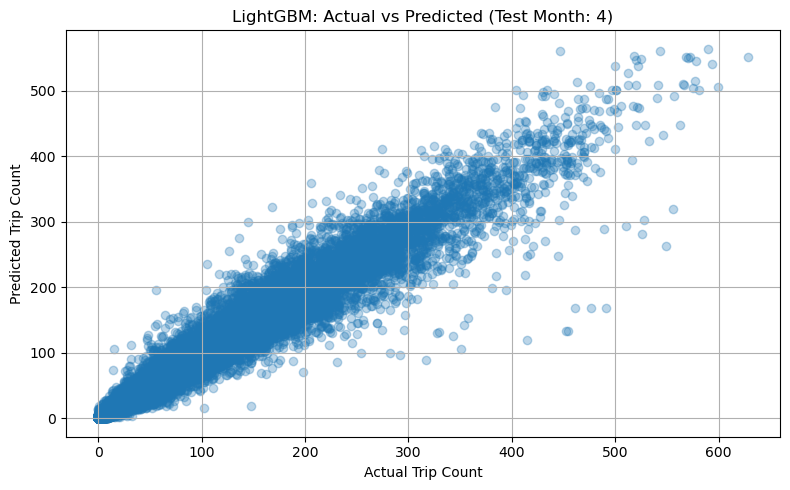

<Figure size 1500x1200 with 0 Axes>

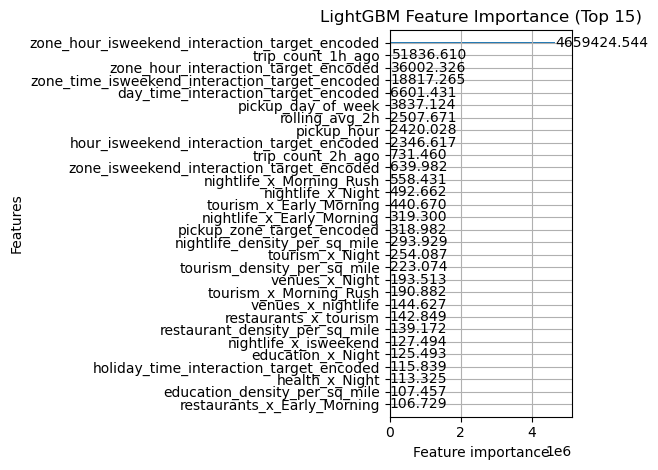

Saved model to: models/hotspot_model_3_to_4.pkl
Loading: /Users/elliekavanagh/Downloads/Monthly Data/Clean_April_Taxi.csv + /Users/elliekavanagh/Downloads/Monthly Data/Clean_May_Taxi.csv
Train shape: (183600, 81)
Test shape: (189720, 81)
Final training columns: Index(['pickup_hour', 'pickup_month', 'pickup_day_of_week', 'is_weekend',
       'nightlife_density_per_sq_mile', 'transit_density_per_sq_mile',
       'hotel_density_per_sq_mile', 'venues_density_per_sq_mile',
       'restaurant_density_per_sq_mile', 'tourism_density_per_sq_mile',
       'education_density_per_sq_mile', 'health_density_per_sq_mile',
       'is_holiday', 'nightlife_x_hotels', 'restaurants_x_tourism',
       'hotels_x_tourism', 'venues_x_nightlife', 'transit_x_all_pois',
       'nightlife_x_isweekend', 'education_x_isweekend', 'health_x_isweekend',
       'venues_x_isweekend', 'tourism_x_isweekend', 'hotel_x_isweekend',
       'transit_x_isweekend', 'restaurants_x_isweekend',
       'nightlife_x_Early_Morning', '

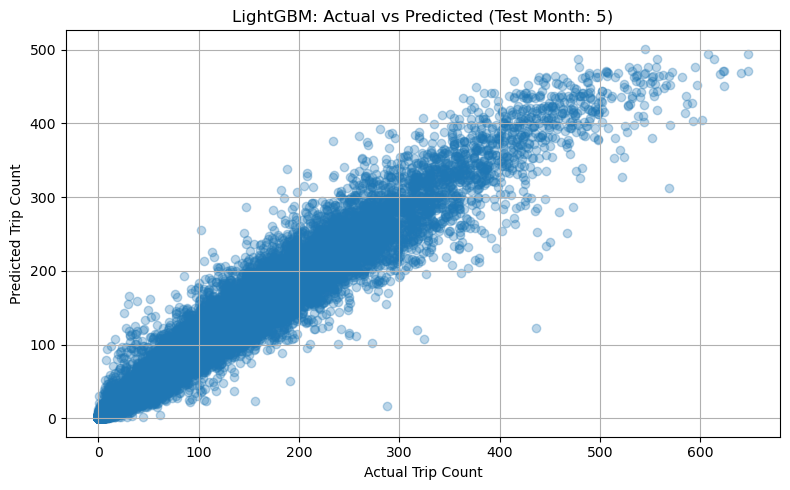

<Figure size 1500x1200 with 0 Axes>

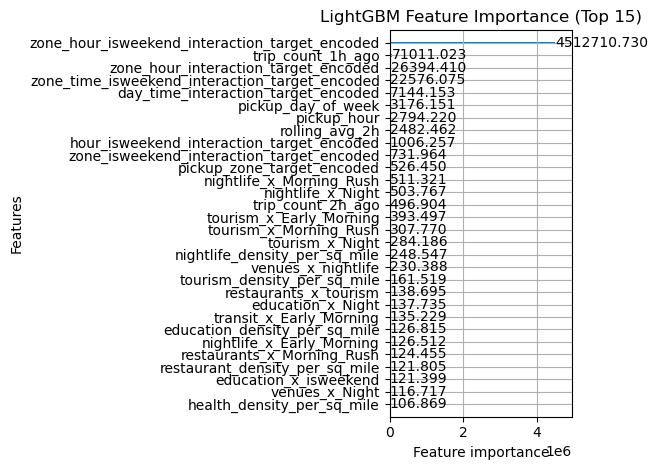

Saved model to: models/hotspot_model_4_to_5.pkl
Loading: /Users/elliekavanagh/Downloads/Monthly Data/Clean_May_Taxi.csv + /Users/elliekavanagh/Downloads/Monthly Data/Clean_June_Taxi.csv
Train shape: (189720, 81)
Test shape: (183600, 81)
Final training columns: Index(['pickup_hour', 'pickup_month', 'pickup_day_of_week', 'is_weekend',
       'nightlife_density_per_sq_mile', 'transit_density_per_sq_mile',
       'hotel_density_per_sq_mile', 'venues_density_per_sq_mile',
       'restaurant_density_per_sq_mile', 'tourism_density_per_sq_mile',
       'education_density_per_sq_mile', 'health_density_per_sq_mile',
       'is_holiday', 'nightlife_x_hotels', 'restaurants_x_tourism',
       'hotels_x_tourism', 'venues_x_nightlife', 'transit_x_all_pois',
       'nightlife_x_isweekend', 'education_x_isweekend', 'health_x_isweekend',
       'venues_x_isweekend', 'tourism_x_isweekend', 'hotel_x_isweekend',
       'transit_x_isweekend', 'restaurants_x_isweekend',
       'nightlife_x_Early_Morning', 'n

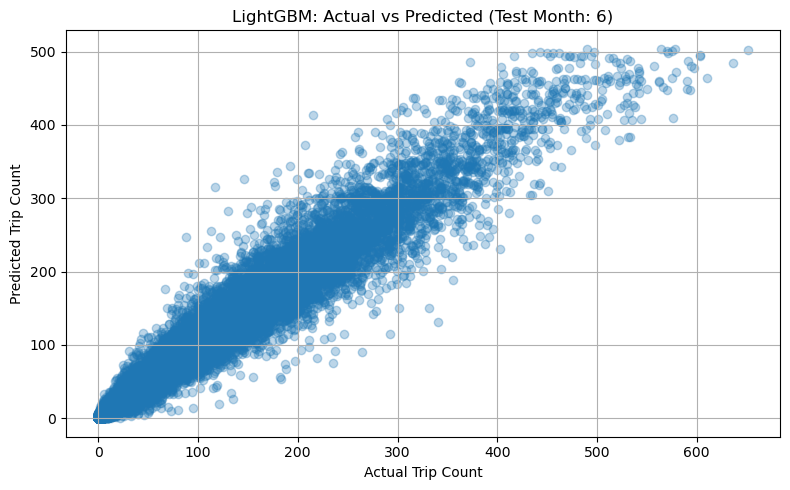

<Figure size 1500x1200 with 0 Axes>

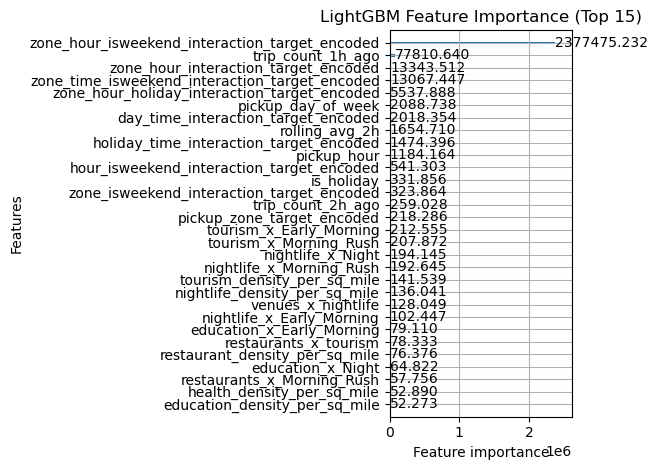

Saved model to: models/hotspot_model_5_to_6.pkl
Loading: /Users/elliekavanagh/Downloads/Monthly Data/Clean_June_Taxi.csv + /Users/elliekavanagh/Downloads/Monthly Data/Clean_July_Taxi.csv
Train shape: (179280, 81)
Test shape: (185256, 81)
Final training columns: Index(['pickup_hour', 'pickup_month', 'pickup_day_of_week', 'is_weekend',
       'nightlife_density_per_sq_mile', 'transit_density_per_sq_mile',
       'hotel_density_per_sq_mile', 'venues_density_per_sq_mile',
       'restaurant_density_per_sq_mile', 'tourism_density_per_sq_mile',
       'education_density_per_sq_mile', 'health_density_per_sq_mile',
       'is_holiday', 'nightlife_x_hotels', 'restaurants_x_tourism',
       'hotels_x_tourism', 'venues_x_nightlife', 'transit_x_all_pois',
       'nightlife_x_isweekend', 'education_x_isweekend', 'health_x_isweekend',
       'venues_x_isweekend', 'tourism_x_isweekend', 'hotel_x_isweekend',
       'transit_x_isweekend', 'restaurants_x_isweekend',
       'nightlife_x_Early_Morning', '

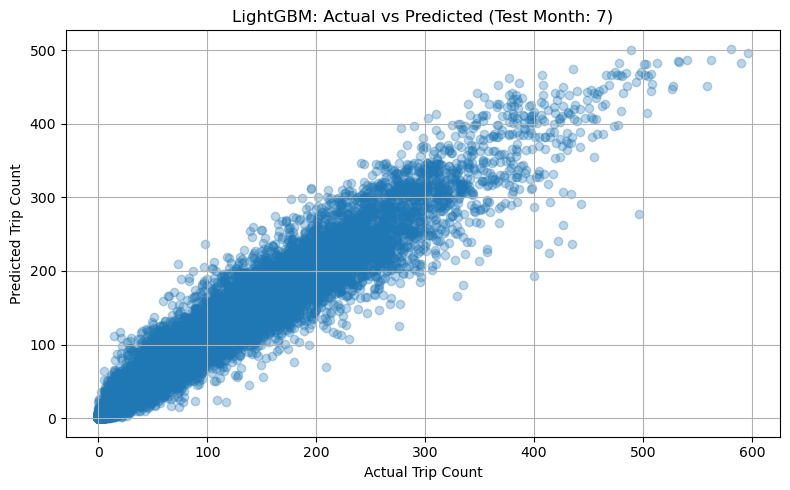

<Figure size 1500x1200 with 0 Axes>

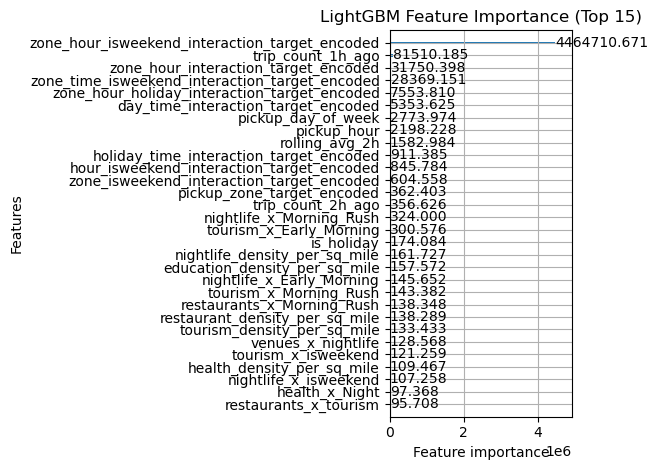

Saved model to: models/hotspot_model_6_to_7.pkl
Loading: /Users/elliekavanagh/Downloads/Monthly Data/Clean_July_Taxi.csv + /Users/elliekavanagh/Downloads/Monthly Data/Clean_August_Taxi.csv
Train shape: (188232, 81)
Test shape: (188232, 81)
Final training columns: Index(['pickup_hour', 'pickup_month', 'pickup_day_of_week', 'is_weekend',
       'nightlife_density_per_sq_mile', 'transit_density_per_sq_mile',
       'hotel_density_per_sq_mile', 'venues_density_per_sq_mile',
       'restaurant_density_per_sq_mile', 'tourism_density_per_sq_mile',
       'education_density_per_sq_mile', 'health_density_per_sq_mile',
       'is_holiday', 'nightlife_x_hotels', 'restaurants_x_tourism',
       'hotels_x_tourism', 'venues_x_nightlife', 'transit_x_all_pois',
       'nightlife_x_isweekend', 'education_x_isweekend', 'health_x_isweekend',
       'venues_x_isweekend', 'tourism_x_isweekend', 'hotel_x_isweekend',
       'transit_x_isweekend', 'restaurants_x_isweekend',
       'nightlife_x_Early_Morning',

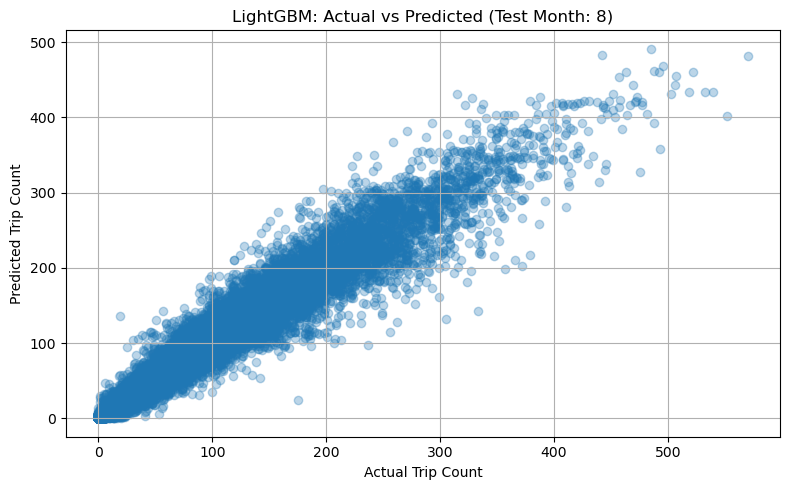

<Figure size 1500x1200 with 0 Axes>

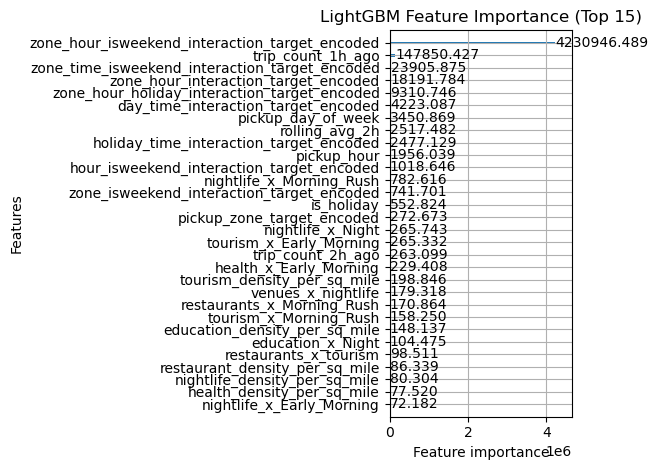

Saved model to: models/hotspot_model_7_to_8.pkl
Loading: /Users/elliekavanagh/Downloads/Monthly Data/Clean_August_Taxi.csv + /Users/elliekavanagh/Downloads/Monthly Data/Clean_September_Taxi.csv
Train shape: (189720, 81)
Test shape: (183600, 81)
Final training columns: Index(['pickup_hour', 'pickup_month', 'pickup_day_of_week', 'is_weekend',
       'nightlife_density_per_sq_mile', 'transit_density_per_sq_mile',
       'hotel_density_per_sq_mile', 'venues_density_per_sq_mile',
       'restaurant_density_per_sq_mile', 'tourism_density_per_sq_mile',
       'education_density_per_sq_mile', 'health_density_per_sq_mile',
       'is_holiday', 'nightlife_x_hotels', 'restaurants_x_tourism',
       'hotels_x_tourism', 'venues_x_nightlife', 'transit_x_all_pois',
       'nightlife_x_isweekend', 'education_x_isweekend', 'health_x_isweekend',
       'venues_x_isweekend', 'tourism_x_isweekend', 'hotel_x_isweekend',
       'transit_x_isweekend', 'restaurants_x_isweekend',
       'nightlife_x_Early_Morn

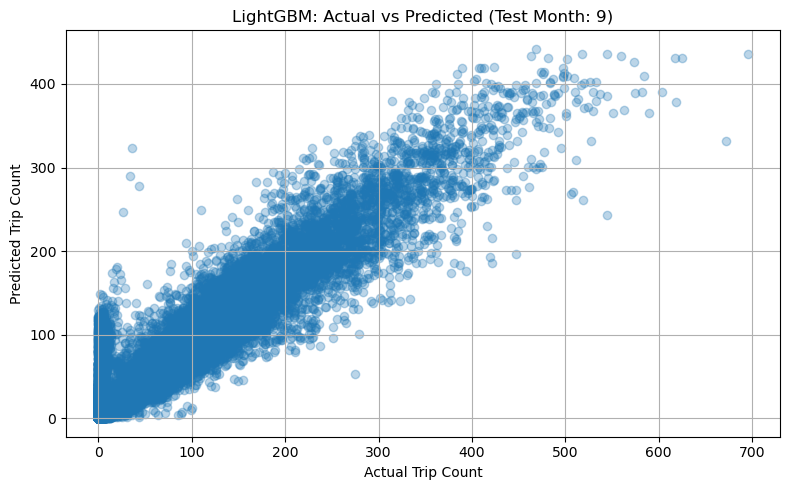

<Figure size 1500x1200 with 0 Axes>

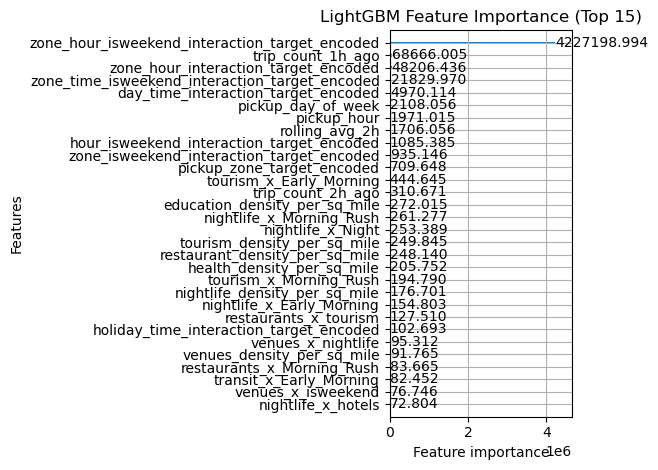

Saved model to: models/hotspot_model_8_to_9.pkl
Loading: /Users/elliekavanagh/Downloads/Monthly Data/Clean_September_Taxi.csv + /Users/elliekavanagh/Downloads/Monthly Data/Clean_October_Taxi.csv
Train shape: (180000, 81)
Test shape: (186000, 81)
Final training columns: Index(['pickup_hour', 'pickup_month', 'pickup_day_of_week', 'is_weekend',
       'nightlife_density_per_sq_mile', 'transit_density_per_sq_mile',
       'hotel_density_per_sq_mile', 'venues_density_per_sq_mile',
       'restaurant_density_per_sq_mile', 'tourism_density_per_sq_mile',
       'education_density_per_sq_mile', 'health_density_per_sq_mile',
       'is_holiday', 'nightlife_x_hotels', 'restaurants_x_tourism',
       'hotels_x_tourism', 'venues_x_nightlife', 'transit_x_all_pois',
       'nightlife_x_isweekend', 'education_x_isweekend', 'health_x_isweekend',
       'venues_x_isweekend', 'tourism_x_isweekend', 'hotel_x_isweekend',
       'transit_x_isweekend', 'restaurants_x_isweekend',
       'nightlife_x_Early_Mor

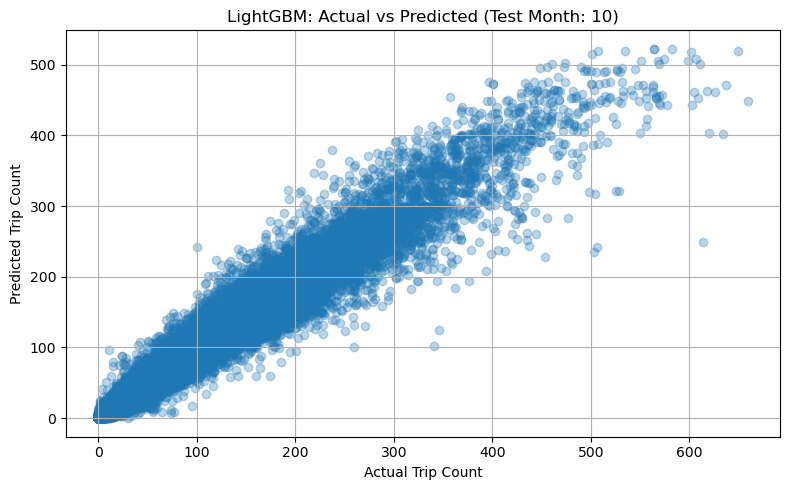

<Figure size 1500x1200 with 0 Axes>

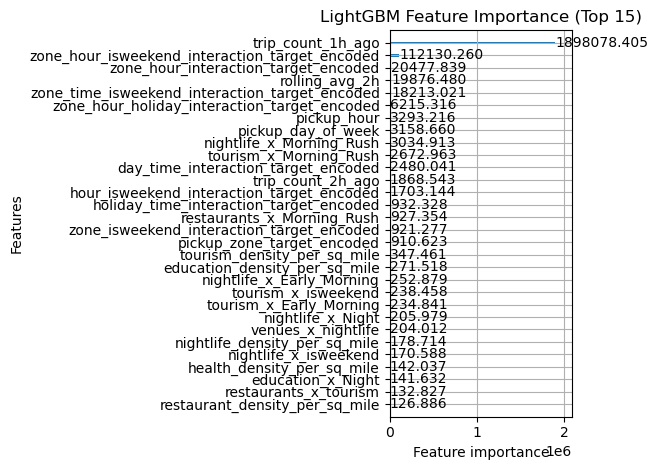

Saved model to: models/hotspot_model_9_to_10.pkl
Loading: /Users/elliekavanagh/Downloads/Monthly Data/Clean_October_Taxi.csv + /Users/elliekavanagh/Downloads/Monthly Data/Clean_November_Taxi.csv
Train shape: (184512, 81)
Test shape: (178560, 81)
Final training columns: Index(['pickup_hour', 'pickup_month', 'pickup_day_of_week', 'is_weekend',
       'nightlife_density_per_sq_mile', 'transit_density_per_sq_mile',
       'hotel_density_per_sq_mile', 'venues_density_per_sq_mile',
       'restaurant_density_per_sq_mile', 'tourism_density_per_sq_mile',
       'education_density_per_sq_mile', 'health_density_per_sq_mile',
       'is_holiday', 'nightlife_x_hotels', 'restaurants_x_tourism',
       'hotels_x_tourism', 'venues_x_nightlife', 'transit_x_all_pois',
       'nightlife_x_isweekend', 'education_x_isweekend', 'health_x_isweekend',
       'venues_x_isweekend', 'tourism_x_isweekend', 'hotel_x_isweekend',
       'transit_x_isweekend', 'restaurants_x_isweekend',
       'nightlife_x_Early_Mor

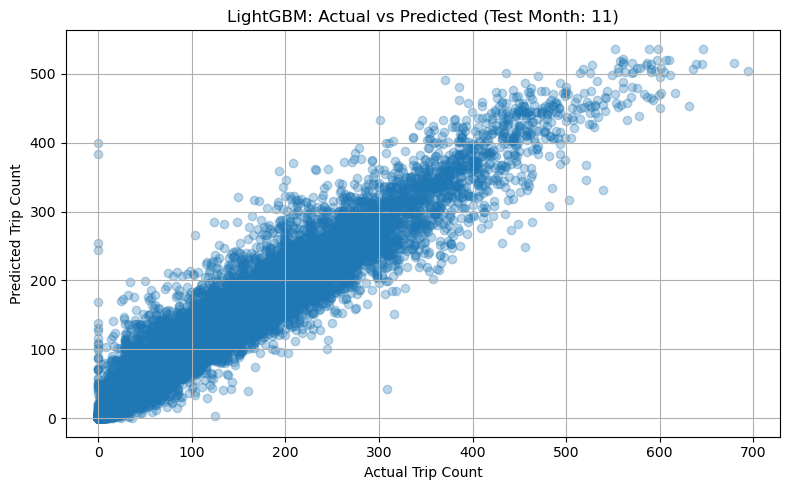

<Figure size 1500x1200 with 0 Axes>

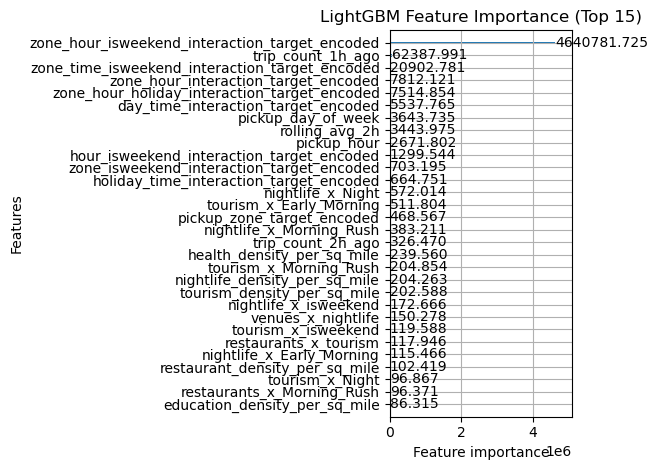

Saved model to: models/hotspot_model_10_to_11.pkl
Loading: /Users/elliekavanagh/Downloads/Monthly Data/Clean_November_Taxi.csv + /Users/elliekavanagh/Downloads/Monthly Data/Clean_December_Taxi.csv
Train shape: (181440, 81)
Test shape: (187488, 81)
Final training columns: Index(['pickup_hour', 'pickup_month', 'pickup_day_of_week', 'is_weekend',
       'nightlife_density_per_sq_mile', 'transit_density_per_sq_mile',
       'hotel_density_per_sq_mile', 'venues_density_per_sq_mile',
       'restaurant_density_per_sq_mile', 'tourism_density_per_sq_mile',
       'education_density_per_sq_mile', 'health_density_per_sq_mile',
       'is_holiday', 'nightlife_x_hotels', 'restaurants_x_tourism',
       'hotels_x_tourism', 'venues_x_nightlife', 'transit_x_all_pois',
       'nightlife_x_isweekend', 'education_x_isweekend', 'health_x_isweekend',
       'venues_x_isweekend', 'tourism_x_isweekend', 'hotel_x_isweekend',
       'transit_x_isweekend', 'restaurants_x_isweekend',
       'nightlife_x_Early_M

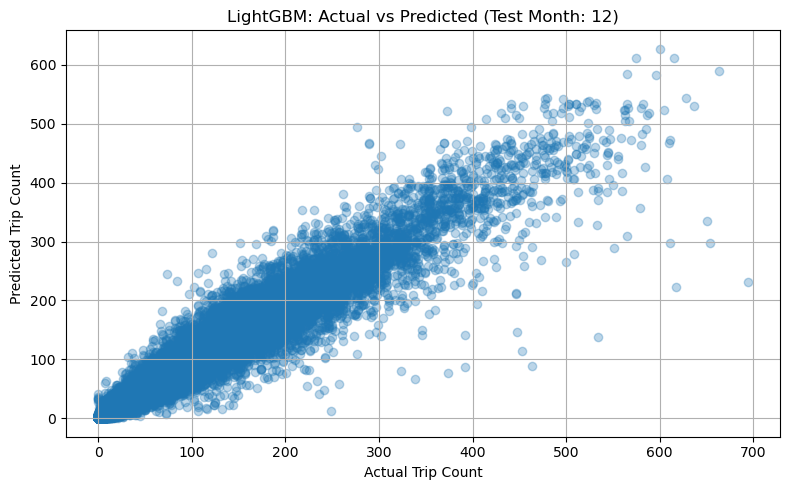

<Figure size 1500x1200 with 0 Axes>

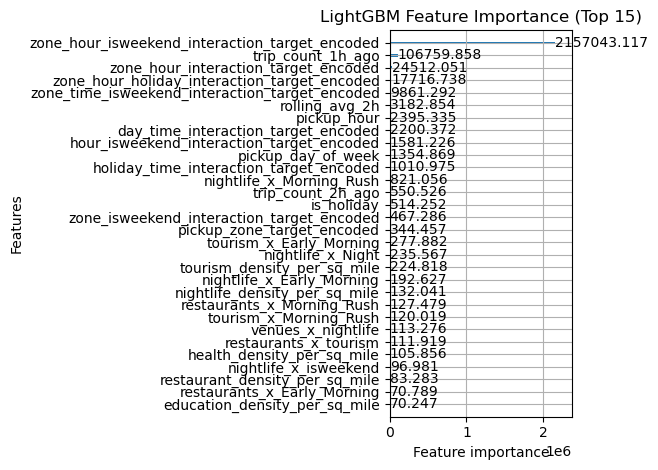

Saved model to: models/hotspot_model_11_to_12.pkl
Saved training results to training_results.csv


In [32]:
import os
import pickle
import pandas as pd

base_dir = "/Users/elliekavanagh/Downloads/Monthly Data"

month_file_map = {
    1: "Clean_January_Taxi.csv",
    2: "Clean_February_Taxi.csv",
    3: "Clean_March_Taxi.csv",
    4: "Clean_April_Taxi.csv",
    5: "Clean_May_Taxi.csv",
    6: "Clean_June_Taxi.csv",
    7: "Clean_July_Taxi.csv",
    8: "Clean_August_Taxi.csv",
    9: "Clean_September_Taxi.csv",
    10: "Clean_October_Taxi.csv",
    11: "Clean_November_Taxi.csv",
    12: "Clean_December_Taxi.csv",  # needed for final test month
}

results = []
os.makedirs("models", exist_ok=True)

for train_month in range(1, 12):
    test_month = train_month + 1

    # Load both train and test month files
    train_file = os.path.join(base_dir, month_file_map[train_month])
    test_file = os.path.join(base_dir, month_file_map[test_month])

    # Check both files exist
    if not os.path.exists(train_file) or not os.path.exists(test_file):
        print(f"Skipping {train_month}->{test_month}: Missing file(s)")
        continue

    print(f"Loading: {train_file} + {test_file}")
    df_train = pd.read_csv(train_file, parse_dates=['pickup_date'])
    df_test = pd.read_csv(test_file, parse_dates=['pickup_date'])

    df = pd.concat([df_train, df_test], ignore_index=True)

    # Double-check both months are present
    available_months = df['pickup_date'].dt.month.unique()
    if train_month not in available_months or test_month not in available_months:
        print(f"Skipping {train_month}->{test_month}: Missing month(s) in combined data: {available_months}")
        continue

    # Train model
    model, params, rmse, mae, r2 = hotspot_prediction(
        df=df,
        train_months=train_month,
        test_months=test_month,
    )
    
    

    # Save model
    model_filename = f"models/hotspot_model_{train_month}_to_{test_month}.pkl"
    with open(model_filename, "wb") as f:
        pickle.dump(model, f)
    print(f"Saved model to: {model_filename}")

    # Save results
    results.append({
        "train_month": train_month,
        "test_month": test_month,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "params": params,
        "model_file": model_filename
    })

# Save training metrics
pd.DataFrame(results).to_csv("training_results.csv", index=False)
print("Saved training results to training_results.csv")
